In [ ]:
#Importamos drive a colab porque es donde tenemos la mezcla de datasets que
#vamos a ulizar
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf

print(tf.__version__)
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models                import Sequential, Model
from tensorflow.keras.layers                import *
from tensorflow.keras.preprocessing.image   import ImageDataGenerator
from tensorflow.keras.utils                 import to_categorical
from tensorflow.keras.optimizers            import SGD, RMSprop, Adam, Adagrad, Adadelta

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight

import matplotlib.pyplot as plt
import random
import cv2
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
import sklearn
import scipy
from skimage.transform import resize
import csv
from tqdm import tqdm
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve,KFold,cross_val_score,StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

2.5.0


In [ ]:
# Para copiar el .zip desde drive a colab
!cp /content/drive/My\ Drive/BD_final.zip ../content/BD_final.zip

# Para descomprimir el .zip
!unzip BD_final.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: BD_final/W/W1953.jpg    
  inflating: BD_final/W/W1954.jpg    
  inflating: BD_final/W/W1955.jpg    
  inflating: BD_final/W/W1956.jpg    
  inflating: BD_final/W/W1957.jpg    
  inflating: BD_final/W/W1958.jpg    
  inflating: BD_final/W/W1959.jpg    
  inflating: BD_final/W/W196.jpg     
  inflating: BD_final/W/W1960.jpg    
  inflating: BD_final/W/W1961.jpg    
  inflating: BD_final/W/W1962.jpg    
  inflating: BD_final/W/W1963.jpg    
  inflating: BD_final/W/W1964.jpg    
  inflating: BD_final/W/W1965.jpg    
  inflating: BD_final/W/W1966.jpg    
  inflating: BD_final/W/W1967.jpg    
  inflating: BD_final/W/W1968.jpg    
  inflating: BD_final/W/W1969.jpg    
  inflating: BD_final/W/W197.jpg     
  inflating: BD_final/W/W1970.jpg    
  inflating: BD_final/W/W1971.jpg    
  inflating: BD_final/W/W1972.jpg    
  inflating: BD_final/W/W1973.jpg    
  inflating: BD_final/W/W1974.jpg    
  inflating: BD_final/W/W19

<class 'PIL.JpegImagePlugin.JpegImageFile'>


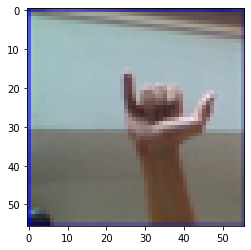

In [ ]:
#Visualizamos una de las imagenes dentro del dataset
from PIL import Image
k=2
pic = Image.open("//content/BD_final/Y/Y999.jpg") 
pix = np.array(pic)
print(type(pic))

plt.imshow(pic.resize((28*k,28*k)))

In [ ]:
from tensorflow.keras.preprocessing.image   import ImageDataGenerator

#Clasificamos las imagenes
bs = 64 #bach size
k = 2
# Generador de imágenes de entrenamiento.
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=(0.3),
        zoom_range=(0.3),
        width_shift_range=(0.2),
        height_shift_range=(0.2),
        validation_split = 0.2,
        brightness_range=(0.05,0.85),
        horizontal_flip=False)

# Carga de imágenes al generador de entrenamiento desde directorio.
train_generator = train_datagen.flow_from_directory(
        '/content/BD_final',
        class_mode='categorical',
        shuffle=True,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        subset = 'training',
        batch_size=bs)

valid_generator = train_datagen.flow_from_directory(
        '/content/BD_final',
        class_mode='categorical',
        shuffle=True,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        subset = 'validation',
        batch_size=bs)

Found 51684 images belonging to 21 classes.
Found 12911 images belonging to 21 classes.


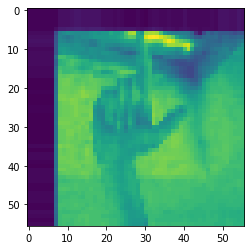

In [ ]:
#Printeado de imagenes
plt.imshow(next(train_generator)[0][2,...,0])
plt.show()

In [ ]:
#Para saber a qué clase se le asocia a cada letra
print(train_generator.class_indices)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'H': 6, 'I': 7, 'K': 8, 'L': 9, 'M': 10, 'N': 11, 'O': 12, 'P': 13, 'Q': 14, 'R': 15, 'T': 16, 'U': 17, 'V': 18, 'W': 19, 'Y': 20}


In [ ]:
#Visualizamos el modelo que vamos a utilizar para el entrenamiento
import tensorflow as tf    
model = tf.keras.applications.VGG19()
model.summary()

574717952/574710816 [==============================] - 3s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [ ]:
##DEFINIMOS EL MODELO
from tensorflow.keras import regularizers
num_classes = 21
epochs = 25

# VGG19
# Importamos el modelo que queremos utilizar.
VGG19_model = tf.keras.applications.VGG19(input_shape=(28*k,28*k,3),
                                          include_top=False,
                                          weights='imagenet')

print(len(VGG19_model.layers))
#Congelamos las 6 primeras capas del modelo que no seran reentrenadas
for layer in VGG19_model.layers[:6]:
  layer.trainable = False

# Creamos un nuevo modelo vacio.
model = tf.keras.Sequential()

# Añadimos el modelo preentrenado como si se tratase de una capa.
model.add(VGG19_model)

# Continuamos añadiendo más capas que sí serán entrenadas...
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(64, kernel_regularizer=regularizers.l2(0.01), activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation = 'softmax'))

80142336/80134624 [==============================] - 1s 0us/step
22


In [ ]:
## EJECUCION DEL MODELO

model.compile(loss="categorical_crossentropy", 
              optimizer= SGD(learning_rate=0.01),
              metrics=['accuracy'])

#Agregamos los callback
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

checkpointer = ModelCheckpoint(filepath='model', verbose=1, save_best_only=True,
                               monitor = 'val_acc', mode = 'max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.000001)
#Procedemos a entrenar
history= model.fit_generator(train_generator,
                             validation_data = valid_generator, 
                             callbacks=[reduce_lr, checkpointer], 
                             epochs=epochs)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
808/808 [==============================] - 170s 189ms/step - loss: 2.0747 - accuracy: 0.6655 - val_loss: 1.3729 - val_accuracy: 0.8379
Epoch 2/25
808/808 [==============================] - 150s 186ms/step - loss: 0.8756 - accuracy: 0.9533 - val_loss: 0.9647 - val_accuracy: 0.9070
Epoch 3/25
808/808 [==============================] - 149s 184ms/step - loss: 0.6203 - accuracy: 0.9711 - val_loss: 0.7387 - val_accuracy: 0.9249
Epoch 4/25
808/808 [==============================] - 151s 187ms/step - loss: 0.4537 - accuracy: 0.9788 - val_loss: 0.5884 - val_accuracy: 0.9279
Epoch 5/25
808/808 [==============================] - 149s 184ms/step - loss: 0.3359 - accuracy: 0.9820 - val_loss: 0.5234 - val_accuracy: 0.9292
Epoch 6/25
808/808 [==============================] - 151s 186ms/step - loss: 0.2506 - accuracy: 0.9859 - val_loss: 0.4608 - val_accuracy: 0.9357
Epoch 7/25
808/808 [==============================] - 149s 184ms/step - loss: 0.1920 - accuracy: 0.9874 - val_loss: 0.4226 -

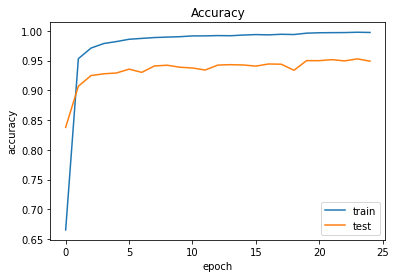

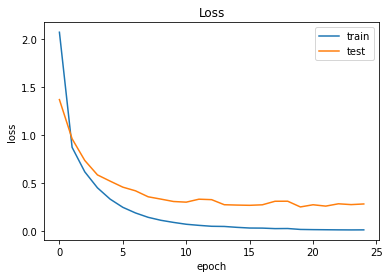

In [ ]:
#Grafico para la precisión
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','test'])
plt.show()

#Grafico para la perdiada
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','test'])
plt.show()

In [ ]:
#guardar modelo
model.save('Modelo_final.h5')